In [33]:
### Do the imports -- no need to change this
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
import copy

In [34]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

In [4]:
!pip install heapdict==1.0.1 matplotlib==3.8.3 numpy==1.26.4 scipy==1.12.0 torch==2.1.1



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [36]:
env = gym.make('CartPole-v1',new_step_api=True)
seed = 0
env.reset(seed=seed)

array([ 0.01369617, -0.02302133, -0.04590265, -0.04834723], dtype=float32)

In [37]:
class Policy(nn.Module): # define the policy network
    def __init__(self, state_size=4, action_size=2, hidden_size=32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        return F.softmax(x, dim=1) # we just consider 1 dimensional probability of action

    def act(self, state):
        state = np.asarray(state)
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        entropy = model.entropy()

        return action.item(), model.log_prob(action), entropy


# Baseline with NN

In [38]:
import torch.nn as nn
import torch.nn.functional as F

class BaselineNetwork(nn.Module):
    def __init__(self, state_size=4, hidden_size=64):
        super().__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.bn1 = nn.LayerNorm(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.LayerNorm(hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, state):
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.bn2(self.fc2(x)))
        return self.fc3(x)


# Testing baselines for REINFORCE

# Baselines

In [39]:
import numpy as np

def naive_baseline(state): # Example Baseline from lecture 4 (for inspiration)
  position = state[0]
  value = 2*(position) # TO BE CHANGED USING YOUR BASELINE
  return value

def baseline_1(state): # TO BE CHANGED USING YOUR BASELINE 1
  cart_position = state[0]   # TODO
  cart_velocity = state[1]
  angle = state[2]
  angular_velocity = state[3]

  value = - 10*np.abs(angle/0.2) - 0.5*np.abs(angular_velocity)

  return value # TODO

def baseline_2(state): # TO BE CHANGED USING YOUR BASELINE 2
  cart_position = state[0]   # TODO
  cart_velocity = state[1]
  angle = state[2]
  angular_velocity = state[3]

  value = - 10*np.abs(angle/0.2) - 0.5*np.abs(cart_position/2)
  return value # TODO




# Generate Trajectories

In [40]:
def generate_trajectories(policy, n_trajectories, env, max_t=1000, seed=0, dim_state=4, print_every=10):
    """
    Runs multiple trajectories with a specified policy and seed
    Returns:
     - trajectories_rewards: shape (n_trajectories,)
     - trajectories_states: shape (n_trajectories, T, state_dim)
     - trajectories_actions: shape (n_trajectories, T)
    """
    trajectories_rewards = []
    trajectories_states = []
    trajectories_actions = []

    for traj_index in range(n_trajectories):
        rewards = []
        states = []
        actions = []

        state = env.reset(seed=seed)
        states.append(state)

        for t in range(max_t):
            action, log_prob = policy.act(state)
            actions.append(action)

            next_state, reward, terminated, truncated, _ = env.step(action)
            rewards.append(reward)
            states.append(next_state)
            state = next_state

            if terminated or truncated:
                break

        trajectories_rewards.append(sum(rewards))
        trajectories_states.append(np.array(states))
        trajectories_actions.append(np.array(actions))

        if traj_index % print_every == 0:
            print(f"Trajectory {traj_index}: reward = {sum(rewards)}")

    return (
        np.array(trajectories_rewards),
        trajectories_states,  # list of arrays of different lengths
        trajectories_actions
    )


# Reinforce

In [41]:
import numpy as np
from collections import deque

import torch

def reinforce_rwd2go(policy, optimizer, seed, env, early_stop=False, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    """
    Implements Reward-to-go and returns only the scores array (not used so far)
    Arguments:
     - policy, optimizer, seed, env, early_stop=False, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100
    Returns:
     - scores
    """
    scores_deque = deque(maxlen=100)
    scores = []
    for e in range(1, n_episodes):
        saved_log_probs = []
        rewards = []
        state, _ = env.reset(seed=seed)
        # Collect trajectory
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, truncated, info = env.step(action)
            rewards.append(reward)
            if done:
                break
        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Recalculate the total reward applying discounted factor
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        rewards_to_go = [sum([discounts[j]*rewards[j+t] for j in range(len(rewards)-t) ]) for t in range(len(rewards))]

        # Calculate the loss
        policy_loss = []
        for i in range(len(saved_log_probs)):
            log_prob = saved_log_probs[i]
            G = rewards_to_go[i]
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            policy_loss.append(-log_prob * G)
        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()

        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
        if early_stop and np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_deque)))
            break
    return scores


def reinforce_rwd2go_baseline(policy, optimizer, seed, baseline, env, target_score=100,
                              early_stop=False, n_episodes=1000, max_t=1000, gamma=0.99, print_every=300):
    """
    Implements REINFORCE with a specified baseline and returns the scores array, the terminal policy and a checkpoint policy (earning +- 10% of the target score)
    Arguments:
     - policy, the initial policy [class(Policy)]
     - optimizer, the chosen optimizer
     - seed, [int]
     - baseline, the baseline function [function]
     - env,
     - target_score = 100, [float]
     - early_stop=False,
     - n_episodes=1000,
     - max_t=1000,
     - gamma=1.0,
     - print_every=100
    Returns:
     - scores
     - max_policy
     - checkpoint_policy
    """
    max_policy_reward = 0
    scores_deque = deque(maxlen=100)
    checkpoint_policy = None
    scores = []
    env.reset(seed=seed)
    for e in range(1, n_episodes):
        saved_log_probs = []
        rewards = []
        baseline_values = []
        state = env.reset()
        # Collect trajectory
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob,ent = policy.act(state)
            baseline_values.append(baseline(state))
            saved_log_probs.append(log_prob)
            state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            rewards.append(reward)
            if done:
                break
        # Calculate total expected reward
        policy_reward = sum(rewards)
        scores_deque.append(policy_reward)
        scores.append(policy_reward)

        # Recalculate the total reward applying discounted factor
        discounts = [gamma ** i for i in range(len(rewards))]
        rewards_to_go = [sum([discounts[j]*rewards[j+t] for j in range(len(rewards)-t) ]) for t in range(len(rewards))]

        # Calculate the loss
        policy_loss = []
        for i in range(len(saved_log_probs)):
            log_prob = saved_log_probs[i]
            G_centered = rewards_to_go[i] - baseline_values[i]
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            policy_loss.append(-log_prob * G_centered)
        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()

        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        #torch.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.0)
        optimizer.step()

        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
        if early_stop and np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_deque)))
            break
        if policy_reward >= 0.90*target_score and policy_reward <= 1.10 * target_score:
            checkpoint_policy = copy.deepcopy(policy)
        if policy_reward >= max_policy_reward:
            max_policy_reward = policy_reward
            max_policy = policy
    return scores, max_policy, checkpoint_policy

# Reward2Go with NN baseline

In [50]:
from math import inf

def reinforce_rwd2go_nn_baseline(policy, optimizer, baseline_net, baseline_optimizer,
                                  env, seed, target_score=-20,
                                  n_episodes=500, max_t=500, gamma=0.99,
                                  entropy_start=0.4, early_stop=True,
                                  print_every=300):

    device = next(policy.parameters()).device
    max_policy_reward = -inf
    scores_deque = deque(maxlen=100)
    checkpoint_policy = None
    scores = []
    env.reset(seed=seed)
    for e in range(1, n_episodes + 1):
          # Entropy decreases as e grows
        frac = (e-1)/(n_episodes-1)
        entropy_coef = entropy_start * (1 - frac) + 0.05 * frac
        saved_log_probs, entropies = [], []
        rewards, states = [], []

        # unpack reset if needed
        state = env.reset()

        # collect trajectory
        for t in range(max_t):
            states.append(state)
            action, log_prob, ent = policy.act(state)
            saved_log_probs.append(log_prob.to(device))
            entropies.append(ent.to(device))

            next_state, reward, done, truncated, _ = env.step(action)
            rewards.append(reward)
            state = next_state
            if done or truncated:
                break

        # compute reward-to-go
        T = len(rewards)
        discounts = [gamma**i for i in range(T)]
        rtg = np.array([
            sum(discounts[j] * rewards[j + i] for j in range(T - i))
            for i in range(T)
        ], dtype=np.float32)

        # prepare tensors
        states_tensor = torch.from_numpy(np.array(states)).float().to(device)
        rtg_tensor    = torch.from_numpy(rtg).float().to(device)
        logp_tensor   = torch.stack(saved_log_probs)
        ent_tensor    = torch.stack(entropies)

        # baseline and advantage
        baseline_vals = baseline_net(states_tensor).squeeze()
        advantage     = rtg_tensor - baseline_vals.detach()
        # optional normalization:
        advantage     = (advantage - advantage.mean()) / (advantage.std() + 1e-8)

        # policy loss w/ entropy bonus
        policy_loss_terms = -logp_tensor * advantage - entropy_coef * ent_tensor
        policy_loss = policy_loss_terms.sum()

        optimizer.zero_grad()
        policy_loss.backward()
        #torch.nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
        optimizer.step()

        # train baseline
        baseline_loss = F.mse_loss(baseline_vals, rtg_tensor)
        baseline_optimizer.zero_grad()
        baseline_loss.backward()
        baseline_optimizer.step()

        # logging & checkpoints
        ep_return = sum(rewards)
        scores.append(ep_return)
        scores_deque.append(ep_return)

        #print(f"Episode {e} Score {ep_return:.2f}")

        if e % print_every == 0:
            print(f"Episode {e} Mean Reward (past 100 values): {np.mean(scores_deque):.2f}")

        #if ep_return > 499:
            #print(f'SOLVED with reward {ep_return:.2f} at episode {e}')
            # torch.save({
            #     'episode': e,
            #     'policy_state_dict': policy.state_dict(),
            #     'optimizer_state_dict': optimizer.state_dict(),
            #     'baseline_state_dict': baseline_net.state_dict(),
            #     'baseline_optimizer_state_dict': baseline_optimizer.state_dict(),
            #     'scores': scores
            # }, f"{checkpoint_path}solved.pth")
            # break

        if ep_return >= 0.9 * target_score and checkpoint_policy is None:
            checkpoint_policy = copy.deepcopy(policy)
            # torch.save({
            #     'episode': e,
            #     'policy_state_dict': policy.state_dict(),
            #     'optimizer_state_dict': optimizer.state_dict(),
            #     'baseline_state_dict': baseline_net.state_dict(),
            #     'baseline_optimizer_state_dict': baseline_optimizer.state_dict(),
            #     'scores': scores
            # }, f"{checkpoint_path}pi2_midrange.pth")

        if ep_return >= max_policy_reward:
            max_policy_reward = ep_return
            max_policy = copy.deepcopy(policy)
            # torch.save({
            #     'episode': e,
            #     'policy_state_dict': policy.state_dict(),
            #     'optimizer_state_dict': optimizer.state_dict(),
            #     'baseline_state_dict': baseline_net.state_dict(),
            #     'baseline_optimizer_state_dict': baseline_optimizer.state_dict(),
            #     'scores': scores
            # }, f"{checkpoint_path}pi1_best.pth")

        # if e % 200 == 0 or e == n_episodes:
        #     torch.save({
        #         'episode': e,
        #         'policy_state_dict': policy.state_dict(),
        #         'optimizer_state_dict': optimizer.state_dict(),
        #         'baseline_state_dict': baseline_net.state_dict(),
        #         'baseline_optimizer_state_dict': baseline_optimizer.state_dict(),
        #         'scores': scores
        #     }, f"{checkpoint_path}checkpoint_episode{e}.pth")

    return scores, max_policy, baseline_net, checkpoint_policy

In [ ]:
np.bool8 = bool
env = gym.make('CartPole-v1',new_step_api=True)

# naive baseline
policy_naive_baseline = Policy().to(device)
optimizer_naive_baseline = optim.Adam(policy_naive_baseline.parameters(), lr=1e-2)
scores_naive_baseline, _, _ = reinforce_rwd2go_baseline(policy_naive_baseline, optimizer_naive_baseline, seed=seed, baseline=naive_baseline, env=env, early_stop=False, n_episodes=1000, gamma=0.99)

env = gym.make('CartPole-v1',new_step_api=True)


# baseline 1
policy_baseline_1 = Policy().to(device)
optimizer_baseline_1 = optim.Adam(policy_baseline_1.parameters(), lr=1e-3)
scores_baseline_1, _, _ = reinforce_rwd2go_baseline(policy_baseline_1, optimizer_baseline_1, seed=seed, baseline=baseline_1, env=env, early_stop=False, n_episodes=1000, gamma=0.99,print_every=100)

env = gym.make('CartPole-v1',new_step_api=True)

# baseline 2
policy_baseline_2 = Policy().to(device)
optimizer_baseline_2 = optim.Adam(policy_baseline_2.parameters(), lr=1e-3)
scores_baseline_2, _, _ = reinforce_rwd2go_baseline(policy_baseline_2, optimizer_baseline_2, seed=seed, baseline=baseline_2, env=env, early_stop=False, n_episodes=1000, gamma=0.99,print_every=100)


env = gym.make('CartPole-v1',new_step_api=True)

# baseline 3
policy_baseline_3 = Policy(hidden_size=128).to(device)
optimizer_baseline_3 = optim.Adam(policy_baseline_3.parameters(), lr=1e-3)
baseline_net = BaselineNetwork(hidden_size=128).to(device)
baseline_optimizer = torch.optim.Adam(baseline_net.parameters(), lr=1e-4, weight_decay=1e-5)
scores_baseline_nn, _, _, _ = reinforce_rwd2go_nn_baseline(policy_baseline_3, optimizer_baseline_3, baseline_net, baseline_optimizer, env=env, seed=seed, n_episodes=1000, early_stop=False,print_every=100 )


Episode 300	Average Score: 95.52


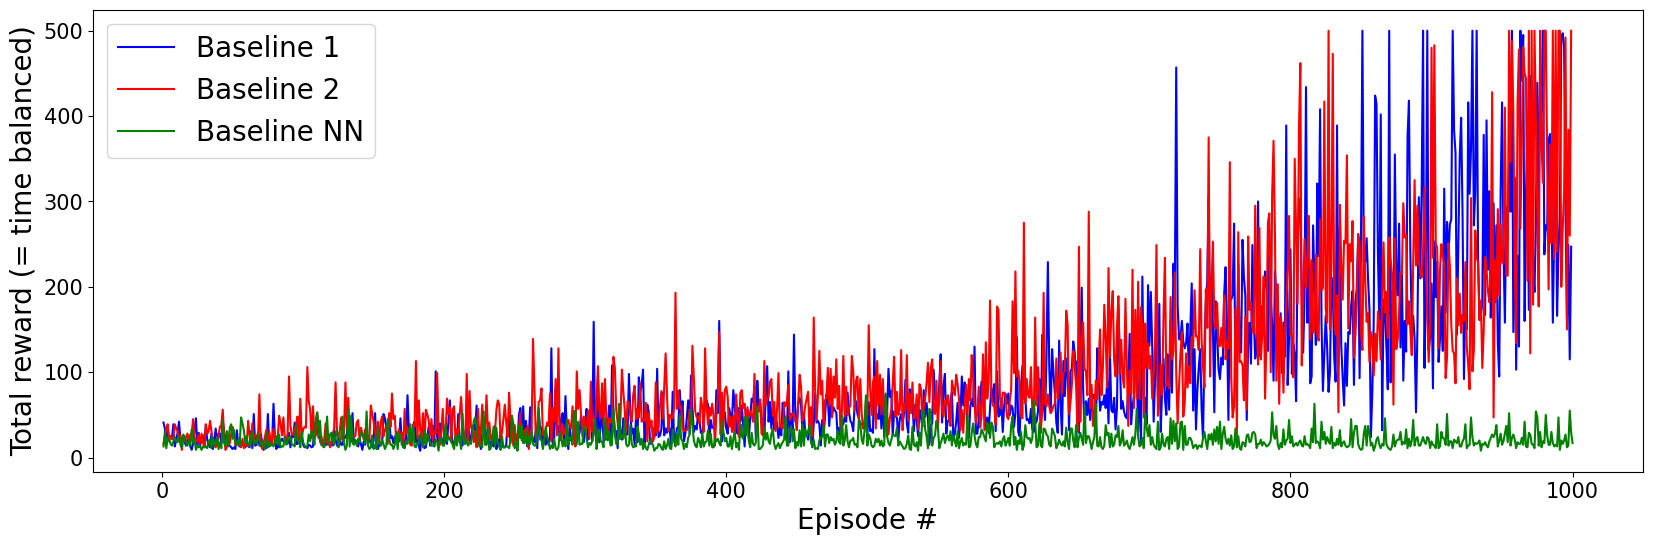

In [46]:
### Plot the learning progress

# Create the plot
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)

# Plot the scores with specified colors and labels
# ax.plot(np.arange(1, len(scores_naive_baseline) + 1), scores_naive_baseline, color='black', label='Naive Baseline')
ax.plot(np.arange(1, len(scores_baseline_1) + 1), scores_baseline_1, color='blue', label='Baseline 1')
ax.plot(np.arange(1, len(scores_baseline_2) + 1), scores_baseline_2, color='red', label='Baseline 2')
ax.plot(np.arange(1, len(scores_baseline_nn) + 1), scores_baseline_nn, color='green', label='Baseline NN')

# Set the labels with a larger font size
ax.set_ylabel('Total reward (= time balanced)', fontsize=20)
ax.set_xlabel('Episode #', fontsize=20)

# Set the tick labels to a larger font size
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a legend with a specified font size
ax.legend(fontsize=20)

# Show the plot
plt.show()

# Generating the preference dataset

In [14]:
# Policy saving

np.bool8 = bool
seed = 0
env = gym.make('MountainCar-v0',new_step_api=True)
env.reset(seed=seed)
target_score = 250

example_policy = Policy().to(device)
optimizer = optim.Adam(example_policy.parameters(), lr=1e-2)
baseline_net = BaselineNetwork().to(device)
baseline_optimizer = torch.optim.Adam(baseline_net.parameters(), lr=1e-3, weight_decay=1e-5)

example_scores, example_policy, example_baseline, example_checkpoint_policy = reinforce_rwd2go_nn_baseline(example_policy, optimizer, baseline_net, baseline_optimizer,
                                                                                                           early_stop=False,env=env, seed=seed,  n_episodes=2500, max_t=1000, print_every=200)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 4x32)

In [ ]:
# Generate preference dataset
pref_dataset_size = 500

env = gym.make('CartPole-v1',new_step_api=True)
trajectories_rewards_pi1, trajectories_states_pi1,trajectories_actions_pi1 = generate_trajectories(example_policy, pref_dataset_size, env=env, max_t=1000, seed = seed, dim_state=4)

env = gym.make('CartPole-v1',new_step_api=True)
trajectories_rewards_pi2, trajectories_states_pi2,trajectories_actions_pi2 = generate_trajectories(example_checkpoint_policy, pref_dataset_size, env=env, max_t=1000, seed = seed, dim_state=4)



In [ ]:
avg_pi1 = np.mean(trajectories_rewards_pi1)
avg_pi2 = np.mean(trajectories_rewards_pi2)
print(avg_pi1, avg_pi2)

In [ ]:
### Plot the learning progress

# Create the plot
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)

# Plot the scores with specified colors and labels
#ax.plot(np.arange(1, len(scores_rwd2go) + 1), scores_rwd2go, color='green', label='No Baseline')
ax.plot(np.arange(1, len(trajectories_rewards_pi1) + 1), trajectories_rewards_pi1, color='blue', label='Trajectories generated from pi_1')
ax.plot(np.arange(1, len(trajectories_rewards_pi2) + 1), trajectories_rewards_pi2, color='red', label='Trajectories generated from pi_2')

# Set the labels with a larger font size
ax.set_ylabel('Total reward', fontsize=20)
ax.set_xlabel('Trajectory #', fontsize=20)

# Set the tick labels to a larger font size
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a legend with a specified font size
ax.legend(fontsize=20)

# Show the plot
plt.show()

# Continuous Mountain Car

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
env = gym.make("MountainCarContinuous-v0",new_step_api=True)

In [ ]:
class ContinuousPolicy(nn.Module):
    def __init__(self, state_dim=2, action_dim=1, hidden_size=64):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)

        self.mean = nn.Linear(hidden_size, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim))  # Learnable std (log-space)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mean = self.mean(x)
        std = torch.exp(self.log_std).clamp(min=1e-3)
        return mean, std

    def act(self, states):  # states: (batch_size, state_dim)
      if isinstance(states, np.ndarray):
          states = torch.from_numpy(states).float().to(device)

      mean, std = self.forward(states)  # both (batch_size, action_dim)
      dist = torch.distributions.Normal(mean, std)
      actions = dist.sample()
      log_probs = dist.log_prob(actions).sum(dim=-1)
      entropies = dist.entropy().sum(dim=-1)

      return (
          actions.cpu().numpy(),          # (batch_size, action_dim)
          log_probs,                      # (batch_size,)
          entropies                       # (batch_size,)
      )


    # def act(self, state):
    #     state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    #     mean, std = self.forward(state)
    #     dist = torch.distributions.Normal(mean, std)
    #     action = dist.sample()
    #     log_prob = dist.log_prob(action).sum(dim=-1)
    #     entropy = dist.entropy().sum()
    #     # Return action, log_prob, and entropy
    #     return action.flatten().cpu().numpy(), log_prob.squeeze(), entropy.squeeze()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class BaselineNetwork(nn.Module):
    def __init__(self, state_size=4, hidden_size=64):
        super().__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.bn1 = nn.LayerNorm(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.LayerNorm(hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, state):
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.bn2(self.fc2(x)))
        return self.fc3(x)


# REINFORCE with NN baseline for CT

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import os
import copy

def reinforce_rwd2go_nn_baseline_ct(policy, optimizer, baseline_net, baseline_optimizer,
                                     env, seed, target_score=250, n_episodes=500, max_t=500,
                                     gamma=0.99, early_stop=True, print_every=100,
                                     checkpoint_path=None, resume=False):
    device = next(policy.parameters()).device
    max_policy_reward = -float('inf')
    scores_deque = deque(maxlen=100)
    checkpoint_policy = None
    scores = []
    start_episode = 1
    max_policy = None

    if resume and checkpoint_path and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        policy.load_state_dict(checkpoint['policy_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        baseline_net.load_state_dict(checkpoint['baseline_state_dict'])
        baseline_optimizer.load_state_dict(checkpoint['baseline_optimizer_state_dict'])
        scores = checkpoint['scores']
        start_episode = checkpoint['episode'] + 1

    for e in range(start_episode, n_episodes + 1):
        log_probs_all, entropies_all, states_all, rtg_all = [], [], [], []
        rewards_batch = [[] for _ in range(env.num_envs)]

        states, _ = env.reset(seed=seed)

        for t in range(max_t):
            states_tensor = torch.from_numpy(states).float().to(device)
            actions, log_probs, entropies = policy.act(states_tensor)
            actions_np = actions.clip(-1.0, 1.0)

            next_states, rewards, terminated, truncated, _ = env.step(actions_np)
            dones = np.logical_or(terminated, truncated)

            log_probs_all.append(log_probs)
            entropies_all.append(entropies)
            states_all.append(states_tensor)

            for i in range(env.num_envs):
                rewards_batch[i].append(rewards[i])

            states = next_states
            if np.all(dones):
                break

        # Compute reward-to-go
        for rewards in rewards_batch:
            r = np.array(rewards, dtype=np.float32)
            rtg = np.zeros_like(r)
            running_add = 0
            for t in reversed(range(len(r))):
                running_add = r[t] + gamma * running_add
                rtg[t] = running_add
            rtg_all.append(rtg)

        states_flat = torch.cat(states_all).to(device)
        log_probs_flat = torch.cat(log_probs_all).to(device)
        entropies_flat = torch.cat(entropies_all).to(device)
        rewards_to_go_flat = torch.tensor(np.concatenate(rtg_all), dtype=torch.float32).to(device)

        baseline_preds = baseline_net(states_flat).squeeze()
        baseline_values = baseline_preds.detach()
        advantage = rewards_to_go_flat - baseline_values
        print(entropies_flat)
        policy_loss = (-log_probs_flat * advantage - 0.01 * entropies_flat).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
        optimizer.step()

        baseline_loss = F.mse_loss(baseline_preds, rewards_to_go_flat)
        baseline_optimizer.zero_grad()
        baseline_loss.backward()
        baseline_optimizer.step()

        # Track and save
        policy_reward = np.mean([sum(r) for r in rewards_batch])
        scores.append(policy_reward)
        scores_deque.append(policy_reward)

        print(f"Reward is {policy_reward}")

        if e % print_every == 0:
            print(f'Episode {e}\tAverage Score: {np.mean(scores_deque):.2f}')

        if early_stop and np.mean(scores_deque) >= 195.0:
            print(f'Environment solved in {e - 100} episodes! Avg Score: {np.mean(scores_deque):.2f}')
            break

        if policy_reward > 90:
            print(f'SOLVED with reward {policy_reward:.2f} at episode {e}')
            torch.save({
                'episode': e,
                'policy_state_dict': policy.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'baseline_state_dict': baseline_net.state_dict(),
                'baseline_optimizer_state_dict': baseline_optimizer.state_dict(),
                'scores': scores
            }, f"{checkpoint_path}solved.pth")
            break

        if policy_reward >= 0.9 * target_score and checkpoint_policy is None:
            checkpoint_policy = copy.deepcopy(policy)
            torch.save({
                'episode': e,
                'policy_state_dict': policy.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'baseline_state_dict': baseline_net.state_dict(),
                'baseline_optimizer_state_dict': baseline_optimizer.state_dict(),
                'scores': scores
            }, f"{checkpoint_path}pi2_midrange.pth")

        if policy_reward >= max_policy_reward:
            max_policy_reward = policy_reward
            max_policy = copy.deepcopy(policy)
            torch.save({
                'episode': e,
                'policy_state_dict': policy.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'baseline_state_dict': baseline_net.state_dict(),
                'baseline_optimizer_state_dict': baseline_optimizer.state_dict(),
                'scores': scores
            }, f"{checkpoint_path}pi1_best.pth")

        if e % 200 == 0 or e == n_episodes:
            torch.save({
                'episode': e,
                'policy_state_dict': policy.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'baseline_state_dict': baseline_net.state_dict(),
                'baseline_optimizer_state_dict': baseline_optimizer.state_dict(),
                'scores': scores
            }, f"{checkpoint_path}checkpoint_episode{e}.pth")

    return scores, max_policy, baseline_net, checkpoint_policy


# Policy

In [ ]:
!pip install 'gym==0.26.2'

In [ ]:
# Policy saving
np.bool8 = bool
seed = 0
env = gym.vector.make("MountainCarContinuous-v0",num_envs=32)
states, _ = env.reset(seed=seed)
target_score = -20

policy_ct = ContinuousPolicy().to(device)
optimizer_ct = optim.Adam(policy_ct.parameters(), lr=5e-4)
baseline_net_ct = BaselineNetwork(state_size=2).to(device)
baseline_optimizer_ct = torch.optim.Adam(baseline_net_ct.parameters(), lr=1e-3, weight_decay=1e-5)

path_save="/content/drive/MyDrive/Weights/"
checkpoint_filename = "mountain_car_continuous_checkpoint.pth"
full_checkpoint_path = os.path.join(path_save, checkpoint_filename)

score_ct, policy_ct, baseline_ct, checkpoint_policy_ct = reinforce_rwd2go_nn_baseline_ct(policy_ct, optimizer_ct, baseline_net_ct, baseline_optimizer_ct,
                                                                                         early_stop=False,env=env, seed=seed,  n_episodes=4500,
                                                                                         max_t=750, print_every=200, checkpoint_path=path_save)


# Generate preference dataset

In [ ]:
pref_dataset_size = 200

# Reload policies
policy_ct = ContinuousPolicy().to(device)
policy_ct.load_state_dict(torch.load('.../final_policy_pi1.pth'))

checkpoint_policy_ct = ContinuousPolicy().to(device)
checkpoint_policy_ct.load_state_dict(torch.load('.../checkpoint_policy_pi2.pth'))


policy_ct.eval()
checkpoint_policy_ct.eval()

env = gym.make("MountainCarContinuous-v0",new_step_api=True)
trajectories_rewards_pi1_ct, trajectories_states_pi1_ct,trajectories_actions_pi1_ct = generate_trajectories(policy_ct, pref_dataset_size, env=env, max_t=1000, seed = seed, dim_state=2)

env = gym.make("MountainCarContinuous-v0",new_step_api=True)
trajectories_rewards_pi2_ct, trajectories_states_pi2_ct,trajectories_actions_pi2_ct = generate_trajectories(checkpoint_policy_ct, pref_dataset_size, env=env, max_t=1000, seed = seed, dim_state=2)

# Plot of the policies evolution

In [ ]:
avg_pi1 = np.mean(trajectories_rewards_pi1_ct)
avg_pi2 = np.mean(trajectories_rewards_pi2_ct)
print(avg_pi1, avg_pi2)

### Plot the learning progress

# Create the plot
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)

# Plot the scores with specified colors and labels
#ax.plot(np.arange(1, len(scores_rwd2go) + 1), scores_rwd2go, color='green', label='No Baseline')
ax.plot(np.arange(1, len(trajectories_rewards_pi1_ct) + 1), trajectories_rewards_pi1_ct, color='blue', label='Trajectories generated from pi_1')
ax.plot(np.arange(1, len(trajectories_rewards_pi2_ct) + 1), trajectories_rewards_pi2_ct, color='red', label='Trajectories generated from pi_2')

# Set the labels with a larger font size
ax.set_ylabel('Total reward', fontsize=20)
ax.set_xlabel('Trajectory #', fontsize=20)

# Set the tick labels to a larger font size
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a legend with a specified font size
ax.legend(fontsize=20)

# Show the plot
plt.show()